In [1]:
%load_ext autoreload
%autoreload 2

# Using the `trajectories` module

The fundamental idea behing the `trajectories` module is to enable a better assessment of the evolution of risk over time.

Currently it proposes to look at the evolution between defined points in time and in the future we plan to also allow use a timeseries-oriented approach.

In this tutorial we present the current possibilities offered by the module.

## `Snapshot`: A snapshot of risk at a specific year

We use `Snapshot` objects to define a point in time. This object acts as a wrapper of the classic risk framework composed of Exposure, Hazard and Vulnerability. As such it is define for a specific year, and contains references to an `Exposures`, a `Hazard`, and an `ImpactFuncSet` object.

Next we show how to instantiate such a `Snapshot`. Note however that they are of little use by themselves, and what you will really use are `SnapshotsCollection` which we present right after.

In [47]:
from climada.engine.impact_calc import ImpactCalc
from climada.util.api_client import Client
from climada.entity import ImpactFuncSet, ImpfTropCyclone
from climada.trajectories.snapshot import Snapshot

client = Client()

exp_present = client.get_litpop(country="Haiti")

haz_present = client.get_hazard(
    "tropical_cyclone",
    properties={
        "country_name": "Haiti",
        "climate_scenario": "historical",
        "nb_synth_tracks": "10",
    },
)
exp_present.assign_centroids(haz_present, distance="approx")

impf_set = ImpactFuncSet([ImpfTropCyclone.from_emanuel_usa()])
exp_present.gdf.rename(columns={"impf_": "impf_TC"}, inplace=True)
exp_present.gdf["impf_TC"] = 1

snap = Snapshot(exp_present, haz_present, impf_set, 2018)

In [48]:
exp_present.gdf["group_id"] = (exp_present.gdf["value"] > 500000) * 1

<Axes: title={'center': 'TC 1: Emanuel 2011'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>

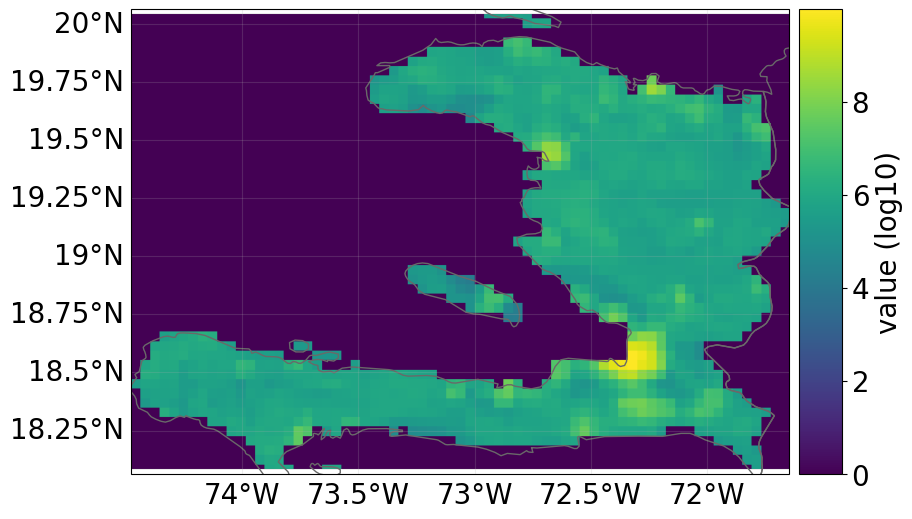

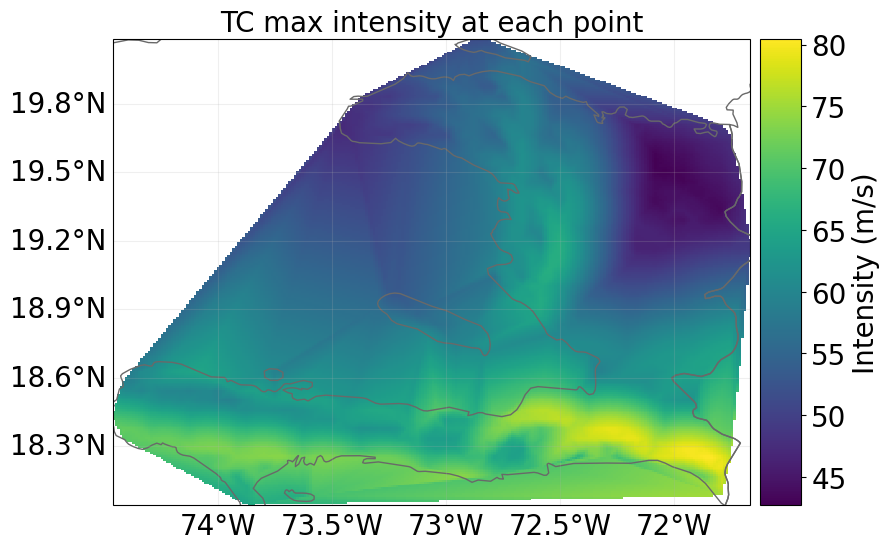

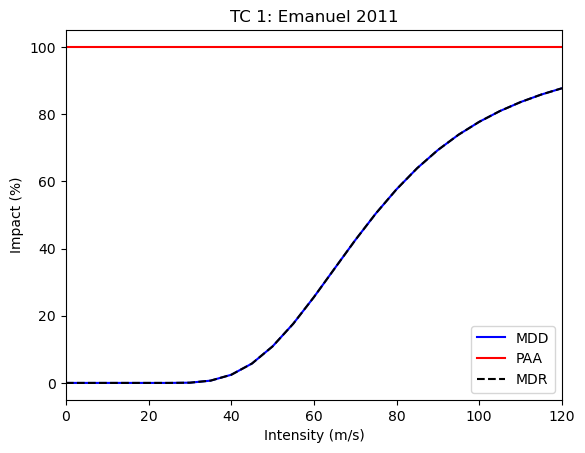

In [49]:
snap.exposure.plot_raster()
snap.hazard.plot_intensity(0)
snap.impfset.plot()

As stated previously, it makes little sense to define a Snapshot alone, so your main entry point should rather be the `SnapshotsCollection`.
For this let us define a future point in time:

In [50]:
import copy

future_year = 2040

exp_future = copy.deepcopy(exp_present)
exp_future.ref_year = future_year
n_years = exp_future.ref_year - exp_present.ref_year + 1
growth_rate = 1.02
growth = growth_rate**n_years
exp_future.gdf["value"] = exp_future.gdf["value"] * growth

haz_future = client.get_hazard(
    "tropical_cyclone",
    properties={
        "country_name": "Haiti",
        "climate_scenario": "rcp60",
        "ref_year": str(future_year),
        "nb_synth_tracks": "10",
    },
)
exp_future.assign_centroids(haz_future, distance="approx")
impf_set = ImpactFuncSet(
    [
        ImpfTropCyclone.from_emanuel_usa(),
        ImpfTropCyclone.from_emanuel_usa(impf_id=2, v_half=60.0),
    ]
)
exp_future.gdf.rename(columns={"impf_": "impf_TC"}, inplace=True)
exp_future.gdf["impf_TC"] = 2

Note how we use only one set of impact function `impf_set`, with one impact function for the present (id=1) and one for the future (id=2).

array([<Axes: title={'center': 'TC 1: Emanuel 2011'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>,
       <Axes: title={'center': 'TC 2: Emanuel 2011'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>],
      dtype=object)

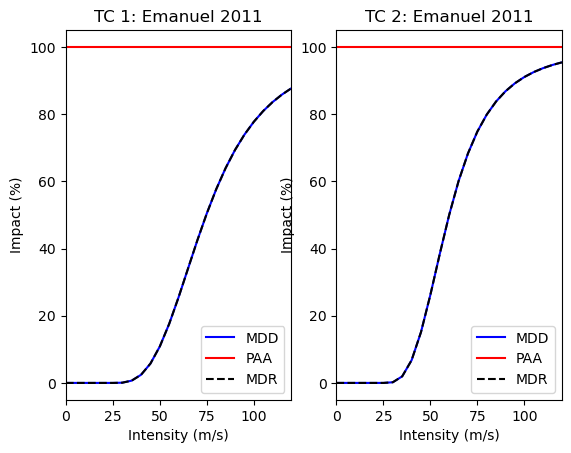

In [51]:
impf_set.plot()

Now we can define our collection of two snapshots, present and future:

In [52]:
from climada.trajectories.snapshot import SnapshotsCollection

snapcol = SnapshotsCollection.from_lists(
    exposure_list=[exp_present, exp_future],
    hazard_list=[haz_present, haz_future],
    impfset=impf_set,
    snapshot_years=[2018, 2040],
)

You can then access the underlying `Snapshot` objects via their year or index:

In [56]:
print(snapcol[0])
print(snapcol[2018])

Snapshot(exposure=<climada.entity.exposures.base.Exposures object at 0x7c0ecd9320e0>, hazard=<climada.hazard.base.Hazard object at 0x7c0fc7f1ad40>, impfset=<climada.entity.impact_funcs.impact_func_set.ImpactFuncSet object at 0x7c0ee6972b90>, year=2018, measure=None)
Snapshot(exposure=<climada.entity.exposures.base.Exposures object at 0x7c0ecd9320e0>, hazard=<climada.hazard.base.Hazard object at 0x7c0fc7f1ad40>, impfset=<climada.entity.impact_funcs.impact_func_set.ImpactFuncSet object at 0x7c0ee6972b90>, year=2018, measure=None)


Based on a collection of snapshots, you can then evaluate a risk trajectory using a `YearlyRiskTrajectory` object.

This object will hold yearly risk metrics for all the years between the different snapshots in the given collection, in this example, from 2020 to 2040. This requires a bit of computation and memory, especially for large regions or extended range of time.

In [89]:
from climada.trajectories.yearly_risk_trajectory import YearlyRiskTrajectory

risk_traj = YearlyRiskTrajectory(snapcol, compute_groups=True)

From this object you can access different yearly risk metrics:

* Annual Average Impact (aai)
* Estimated impact for different return periods (100, 500 and 1000 by default)
* (if `compute_groups` was set to True) Annual Average Impact per group_id from the exposure (when group is not NaN)

In [58]:
risk_traj.total_risk_metrics

,period,group,measure,metric,risk
0,2018-2040,NaN,no_measure,aai,9.960186e+09
1,2018-2040,NaN,no_measure,rp_100,3.288826e+11
2,2018-2040,NaN,no_measure,rp_1000,8.369369e+11
3,2018-2040,NaN,no_measure,rp_500,8.369369e+11
4,2018-2040,0.0,no_measure,aai,1.487445e+07
5,2018-2040,1.0,no_measure,aai,9.945312e+09


In [59]:
risk_traj.yearly_risk_metrics

,year,group,measure,metric,risk
0,2018,<NA>,no_measure,aai,1.840432e+08
1,2019,<NA>,no_measure,aai,2.055335e+08
2,2020,<NA>,no_measure,aai,2.271876e+08
3,2021,<NA>,no_measure,aai,2.490056e+08
4,2022,<NA>,no_measure,aai,2.709873e+08
...,...,...,...,...,...
133,2038,1,no_measure,aai,6.440116e+08
134,2039,0,no_measure,aai,1.003259e+06
135,2039,1,no_measure,aai,6.687412e+08
136,2040,0,no_measure,aai,1.040877e+06


You can also plot the "components" of the change in risk via a waterfall graph, both over the whole period:

<Axes: title={'center': 'Risk at 2018 and 2040 (Annual Average impact)'}, ylabel='USD'>

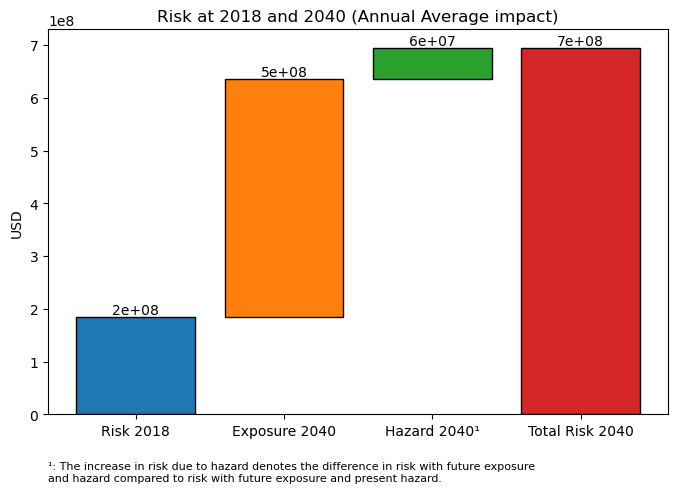

In [60]:
risk_traj.plot_waterfall()

And on a yearly basis:

<Axes: title={'center': 'Risk between 2018 and 2040 (Annual Average impact)'}, xlabel='Year', ylabel='USD'>

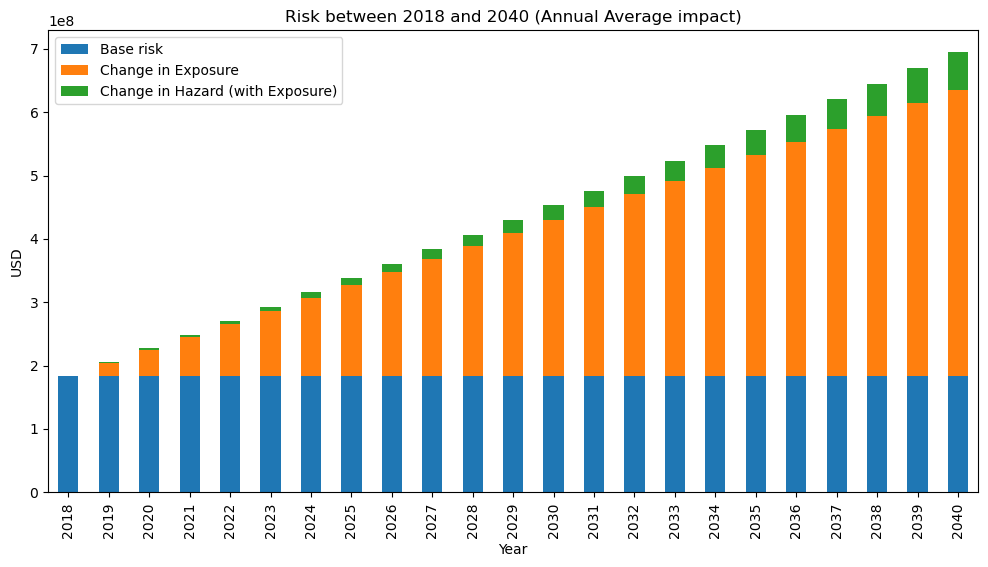

In [61]:
risk_traj.plot_yearly_waterfall()

Note that we plot the change in risk due to exposure change only, and the additional change when considering change in hazard. As vulnerability is most often non-linear, this should be considered with caution.

### DiscRates

To correctly assess the future risk, you may want to apply a discount rate, in order to express future costs in net present value.

This can easily be done using the `DiscRates` class:

In [62]:
from climada.entity import DiscRates
import numpy as np

year_range = np.arange(exp_present.ref_year, exp_future.ref_year + 1)
annual_discount_stern = np.ones(n_years) * 0.014
discount_stern = DiscRates(year_range, annual_discount_stern)

In [85]:
discouted_risk_traj = YearlyRiskTrajectory(snapcol, risk_disc=discount_stern)

In [86]:
discouted_risk_traj.yearly_risk_metrics

,year,measure,metric,risk
0,2018,no_measure,aai,1.840432e+08
1,2019,no_measure,aai,2.026958e+08
2,2020,no_measure,aai,2.209575e+08
3,2021,no_measure,aai,2.388335e+08
4,2022,no_measure,aai,2.563287e+08
...,...,...,...,...
87,2036,no_measure,rp_1000,3.686544e+10
88,2037,no_measure,rp_1000,3.757496e+10
89,2038,no_measure,rp_1000,3.826012e+10
90,2039,no_measure,rp_1000,3.892142e+10


<Axes: xlabel='year', ylabel='risk'>

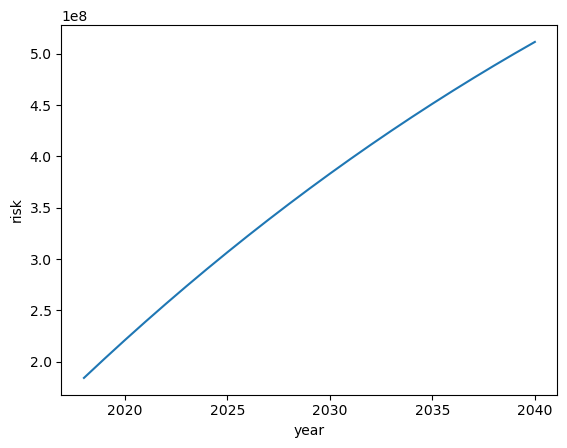

In [91]:
import seaborn as sns

sns.lineplot(
    discouted_risk_traj.yearly_risk_metrics.loc[
        discouted_risk_traj.yearly_risk_metrics["metric"] == "aai"
    ],
    x="year",
    y="risk",
)

<Axes: xlabel='year', ylabel='risk'>

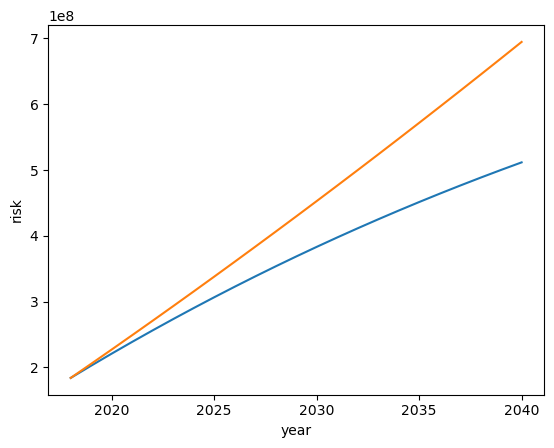

In [ ]:
sns.lineplot(
    risk_traj.yearly_risk_metrics.loc[
        discouted_risk_traj.yearly_risk_metrics["metric"] == "aai"
    ],
    x="year",
    y="risk",
    ax=g,
)